### Load libraries

In [247]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

### Data collection

In [3]:
train_df = pd.read_excel('Data\Data_Train.xlsx')
test_df = pd.read_excel('Data\Test_set.xlsx')

print("Train shape:",train_df.shape[0])
print("Test shape:",test_df.shape[0])

Train shape: 10683
Test shape: 2671


### Feature engineering

In [4]:
# concat the train and test datasets
df = pd.concat([train_df, test_df], ignore_index=True, axis=0)

In [5]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0


In [6]:
# check the data types of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13354 entries, 0 to 13353
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            10683 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.1+ MB


In [7]:
# check for null values
df.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 1
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           1
Additional_Info       0
Price              2671
dtype: int64

In [8]:
# check the unique values
print("Airline:",df.Airline.unique())
print("Source:",df.Source.unique())
print("Destination:",df.Destination.unique())
print("Total_Stops:",df.Total_Stops.unique())
print("Additional_Info:",df.Additional_Info.unique())

Airline: ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
Source: ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
Destination: ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']
Total_Stops: ['non-stop' '2 stops' '1 stop' '3 stops' nan '4 stops']
Additional_Info: ['No info' 'In-flight meal not included' 'No check-in baggage included'
 '1 Short layover' 'No Info' '1 Long layover' 'Change airports'
 'Business class' 'Red-eye flight' '2 Long layover']


In [9]:
# remove the nan value from the Total Stops
# df = df[~df.Total_Stops.isnull()==True]

In [10]:
# replace 'non-stop' by '0 stops' and remove the 'stops'
df['Total_Stops'] = df['Total_Stops'].apply(lambda x: str(x).replace('non-stop', '0 stops'))
df['Total_Stops'] = df['Total_Stops'].apply(lambda x: x.split(' ')[0])

In [11]:
# fill missing values with 'Missing' text and mean
df.Route = df.Route.fillna('Missing')
Total_Stops_median = df.Total_Stops.median()
df.Total_Stops = df.Total_Stops.apply(lambda x: Total_Stops_median if x == 'nan' else x).astype(int)

In [12]:
# capitalize the first letter of additional info
df['Additional_Info'] = df['Additional_Info'].apply(lambda x: x.capitalize())

In [13]:
# convert the Date of journey, Dep time to date format
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

In [14]:
# extract the date, month, year and weekday from date of journey
df['Dep_Day'] = df['Date_of_Journey'].apply(lambda x: x.day)
df['Dep_Month'] = df['Date_of_Journey'].apply(lambda x: x.month)
df['Dep_Year'] = df['Date_of_Journey'].apply(lambda x: x.year)
df['Dep_Weekday'] = df['Date_of_Journey'].apply(lambda x: x.weekday())

In [15]:
# split the dep time and arrival time
df['Dep_Time'] = df['Dep_Time'].str.split(' ').str[0]
df['Arrival_Time'] = df['Arrival_Time'].str.split(' ').str[0]

In [16]:
# convert the dep time and arrival time to time format
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.time
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'], format='%H:%M').dt.time

In [17]:
# create date of arrival column
df['Date_of_Arrival'] = (df.apply(lambda x: pd.Timestamp.combine(x.Date_of_Journey, x.Dep_Time), axis=1) 
                        + pd.to_timedelta(df.Duration)).dt.date

In [18]:
# extract the date, month, year and weekday from date of arrival
df['Arrival_Day'] = df['Date_of_Arrival'].apply(lambda x: x.day)
df['Arrival_Month'] = df['Date_of_Arrival'].apply(lambda x: x.month)
df['Arrival_Year'] = df['Date_of_Arrival'].apply(lambda x: x.year)
df['Arrival_Weekday'] = df['Date_of_Arrival'].apply(lambda x: x.weekday())

In [19]:
# split dep time and arrival time in hours and minutes
df['Dep_Hour'] = df['Dep_Time'].apply(lambda x: x.hour)
df['Dep_Min'] = df['Dep_Time'].apply(lambda x: x.minute)
df['Arrival_Hour'] = df['Arrival_Time'].apply(lambda x: x.hour)
df['Arrival_Min'] = df['Arrival_Time'].apply(lambda x: x.minute)

In [20]:
# get dep and arrival time of day
def get_timeofday(time):
    if (time < 6):
        return 'Early Morning'
    elif (time >= 6 and time < 12):
        return 'Morning'
    elif (time >= 12 and time < 16):
        return 'Afternoon'
    elif (time >= 16 and time < 20):
        return 'Evening'
    else:
        return 'Night'

df['Dep_timeofday'] = df['Dep_Hour'].apply(get_timeofday)   
df['Arrival_timeofday'] = df['Arrival_Hour'].apply(get_timeofday) 

In [21]:
# define function to get hours from duration
def get_hours(duration):
    if 'h' in duration:
        return int(duration.split(' ')[0].strip('h'))
    else:
        return 0

# define function to get minutes from duration
def get_minutes(duration):
    min = duration.split(' ')
    if len(min)==1:
        if 'm' in duration:
            return int(duration.split(' ')[0].strip('m'))
        else:
            return 0
    else:
        return int(duration.split(' ')[1].strip('m'))

# calculate the duration in minutes
df['Duration'] = df['Duration'].apply(lambda x: get_hours(x)*60 + get_minutes(x))

In [22]:
# create seperate columns from the route for each values in the route
for i in df.index:
    route_list = df.Route[i].split(' → ')
    for r in range(len(route_list)):
        if not 'Route_'+str(r+1) in df.columns:
            df['Route_'+str(r+1)] = 'None'
        df['Route_'+str(r+1)][i] = route_list[r]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [23]:
# define booking class for each booking
bclass = {
            'IndiGo': 'Economy',
            'Air India': 'Economy',
            'Jet Airways': 'Economy',
            'SpiceJet': 'Economy',
            'Multiple carriers': 'Economy',
            'GoAir': 'Economy',
            'Vistara': 'Economy',
            'Air Asia': 'Economy',
            'Vistara Premium economy': 'Premium Economy',
            'Jet Airways Business': 'Business',
            'Multiple carriers Premium economy': 'Premium Economy',
            'Trujet': 'Economy'
        }

df['Class'] = df['Airline'].map(bclass)

In [24]:
# drop columns that are not required
df.drop(['Date_of_Journey', 'Date_of_Arrival', 'Route', 'Dep_Time', 'Arrival_Time'], axis=1, inplace=True)

In [25]:
# get the column names
df.columns.values

array(['Airline', 'Source', 'Destination', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Dep_Day', 'Dep_Month', 'Dep_Year',
       'Dep_Weekday', 'Arrival_Day', 'Arrival_Month', 'Arrival_Year',
       'Arrival_Weekday', 'Dep_Hour', 'Dep_Min', 'Arrival_Hour',
       'Arrival_Min', 'Dep_timeofday', 'Arrival_timeofday', 'Route_1',
       'Route_2', 'Route_3', 'Route_4', 'Route_5', 'Route_6', 'Class'],
      dtype=object)

In [26]:
# reorder the columns
df = df[['Airline', 'Class', 'Source', 'Destination', 'Duration', 'Dep_timeofday', 'Dep_Day', 'Dep_Month', 'Dep_Year',
         'Dep_Weekday', 'Dep_Hour', 'Dep_Min', 'Arrival_timeofday', 'Arrival_Day', 'Arrival_Month', 'Arrival_Year',
         'Arrival_Weekday', 'Arrival_Hour', 'Arrival_Min', 'Additional_Info', 'Total_Stops', 
         'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5', 'Route_6', 'Price']]

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13354 entries, 0 to 13353
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Airline            13354 non-null  object 
 1   Class              13354 non-null  object 
 2   Source             13354 non-null  object 
 3   Destination        13354 non-null  object 
 4   Duration           13354 non-null  int64  
 5   Dep_timeofday      13354 non-null  object 
 6   Dep_Day            13354 non-null  int64  
 7   Dep_Month          13354 non-null  int64  
 8   Dep_Year           13354 non-null  int64  
 9   Dep_Weekday        13354 non-null  int64  
 10  Dep_Hour           13354 non-null  int64  
 11  Dep_Min            13354 non-null  int64  
 12  Arrival_timeofday  13354 non-null  object 
 13  Arrival_Day        13354 non-null  int64  
 14  Arrival_Month      13354 non-null  int64  
 15  Arrival_Year       13354 non-null  int64  
 16  Arrival_Weekday    133

In [28]:
df.head()

,Airline,Class,Source,Destination,Duration,Dep_timeofday,Dep_Day,Dep_Month,Dep_Year,Dep_Weekday,...,Arrival_Min,Additional_Info,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6,Price
0,IndiGo,Economy,Banglore,New Delhi,170,Night,24,3,2019,6,...,10,No info,0,BLR,DEL,None,None,None,None,3897.0
1,Air India,Economy,Kolkata,Banglore,445,Early Morning,1,5,2019,2,...,15,No info,2,CCU,IXR,BBI,BLR,None,None,7662.0
2,Jet Airways,Economy,Delhi,Cochin,1140,Morning,9,6,2019,6,...,25,No info,2,DEL,LKO,BOM,COK,None,None,13882.0
3,IndiGo,Economy,Kolkata,Banglore,325,Evening,12,5,2019,6,...,30,No info,1,CCU,NAG,BLR,None,None,None,6218.0
4,IndiGo,Economy,Banglore,New Delhi,285,Evening,1,3,2019,4,...,35,No info,1,BLR,NAG,DEL,None,None,None,13302.0


In [29]:
# split the train and test dataset
train_df = df[:train_df.shape[0]]
test_df = df[train_df.shape[0]:]

# drop price from test_df
test_df.drop('Price', axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
print("Train shape:",train_df.shape)
print("Test shape:",test_df.shape)

Train shape: (10683, 28)
Test shape: (2671, 27)


### EDA

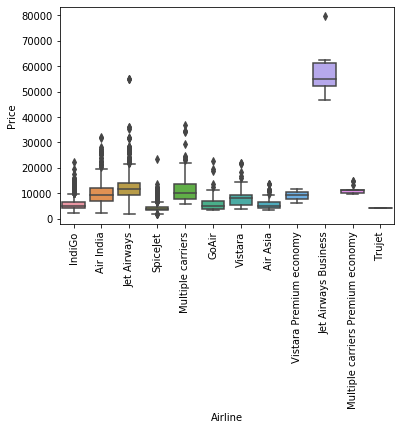

In [31]:
# plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.boxplot(train_df.Airline, train_df.Price)

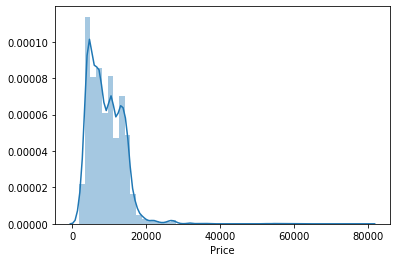

In [312]:
# check price distribution
sns.distplot(train_df.Price)

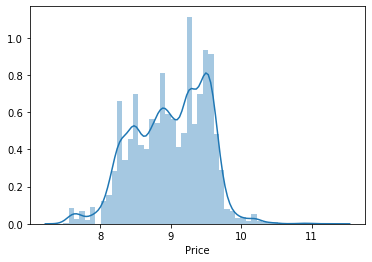

In [33]:
# check log price distribution
sns.distplot(np.log(train_df.Price))

### One hot encoding

In [34]:
columns = ['Airline', 'Class', 'Source', 'Destination', 'Duration',
       'Dep_timeofday', 'Dep_Day', 'Dep_Month', 'Dep_Year', 'Dep_Weekday',
       'Dep_Hour', 'Dep_Min', 'Arrival_timeofday', 'Arrival_Day',
       'Arrival_Month', 'Arrival_Year', 'Arrival_Weekday', 'Arrival_Hour',
       'Arrival_Min', 'Additional_Info', 'Total_Stops', 'Price']

In [35]:
train_df = pd.get_dummies(train_df)
# train_df = pd.get_dummies(train_df[columns])

In [36]:
X = train_df.drop('Price', axis=1)
y = np.log(train_df.Price)

### Train test split

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=1)

### Model outline

In [38]:
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [102]:
# define root mean square log error function
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.exp(y_true), np.exp(y_pred)))

#### XGBoost

In [97]:
# define the model
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train,y_train)

[19:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [98]:
# check score on train dataset
y_pred = xgbr.predict(X_train)
print("Score:", xgbr.score(X_train,y_train))
print('RMSLE:', rmsle(y_train, y_pred))

Score: 0.8785349449666788
RMSLE: 0.17848041761250238


In [99]:
# check score on validation dataset
y_pred = xgbr.predict(X_val)
print('Score:', xgbr.score(X_val,y_val))
print('RMSLE:', np.sqrt(mean_squared_log_error(np.exp(y_val), np.exp(y_pred))))

Score: 0.8732670252119894
RMSLE: 0.18396880953592074


In [103]:
# define a custom scorer
my_scorer = make_scorer(rmsle, greater_is_better=False)

In [105]:
# score = cross_val_score(xgbr, X, y, scoring='neg_mean_squared_log_error', cv=5)
score = cross_val_score(xgbr, X, y, scoring=my_scorer, cv=5)
print("RMSLE:", abs(score.mean()))

[19:20:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:21:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:21:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:21:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:21:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.18204617504470466


#### Hyper parameter  tuning XGBoost

In [106]:
n_estimators = [int(x) for x in np.linspace(start=100,stop=1200,num=12)]
learning_rate = [0.05, 0.1, 0.2, 0.3, 0.5, 0.6]
max_depth = [int(x) for x in np.linspace(start=5,stop=30,num=6)]
subsample = [0.7, 0.8, 1]
min_child_weight = [1, 3, 5, 7]

parameters = {
    'n_estimators': [1000],
    'learning_rate': [0.3],
    'max_depth': [10],
    'subsample': [1],
    'min_child_weight': [1]
}

xgbr = xgb.XGBRegressor()

In [108]:
# define randomized search cross validation
rsearch = RandomizedSearchCV(estimator=xgbr, param_distributions=parameters, scoring=my_scorer, cv=5, n_iter=10, verbose=1, random_state=1)

In [109]:
# fit the train dataset
rsearch.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[19:22:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


[19:25:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(),
                   param_distributions={'learning_rate': [0.3],
                                        'max_depth': [10],
                                        'min_child_weight': [1],
                                        'n_estimators': [1000],
                                        'subsample': [1]},
                   random_state=1,
                   scoring=make_scorer(rmsle, greater_is_better=False),
                   verbose=1)

In [111]:
# check the best score
print("RMSLE:", abs(rsearch.best_score_))

RMSLE: 0.12281550683307751


In [112]:
# find the best parameter
rsearch.best_params_

{'subsample': 1,
 'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.3}

In [113]:
# check the validation score
y_pred = rsearch.predict(X_val)
print('RMSLE:', rmsle(y_val, y_pred))

RMSLE: 0.11927736382838959


#### LightGBM

In [287]:
import lightgbm as lgb

In [288]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=500)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0169205


LGBMRegressor()

In [289]:
# check score on train dataset
y_pred = lgbm.predict(X_train)
print("Score:", lgbm.score(X_train,y_train))
print('RMSLE:', rmsle(y_train, y_pred))
np.sqrt(mean_squared_log_error(np.exp(y_train), np.exp(y_pred)))

Score: 0.952308431022703
RMSLE: 0.11183774725118491


0.11183774725118491

In [290]:
# check score on validation dataset
y_pred = lgbm.predict(X_val)
print("Score:", lgbm.score(X_val,y_val))
print('RMSLE:', rmsle(y_val, y_pred))

Score: 0.936657656765881
RMSLE: 0.1300615686381023


#### Hyper parameter tuning LightGBM

In [291]:
n_estimators = [int(x) for x in np.linspace(start=100,stop=1200,num=12)]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
max_depth = [int(x) for x in np.linspace(start=5,stop=30,num=6)]
subsample = [0.7, 0.8, 1]
min_child_weight = [1, 3, 5, 7]
#     'task': 'train',
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 10,
parameters = {
        'objective': ['regression'],
        'boosting': ['gbdt'],
        'num_iterations': n_estimators,
        'learning_rate': learning_rate, 
        'num_leaves': [20, 30, 40, 50, 70],
        'max_depth': [5, 10, 15, 20, 30],   
        'min_data_in_leaf': [5, 7, 11, 15, 18],  
        'max_bin': [2, 4, 7, 10, 20, 30] ,
        'metric': ['l2_root', 'l2']
         }

In [292]:
rsearch_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=parameters, scoring=my_scorer, cv=5, n_iter=100, verbose=1, random_state=1)

In [293]:
rsearch_lgbm.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.5min finished


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'boosting': ['gbdt'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3, 0.5],
                                        'max_bin': [2, 4, 7, 10, 20, 30],
                                        'max_depth': [5, 10, 15, 20, 30],
                                        'metric': ['l2_root', 'l2'],
                                        'min_data_in_leaf': [5, 7, 11, 15, 18],
                                        'num_iterations': [100, 200, 300, 400,
                                                           500, 600, 700, 800,
                                                           900, 1000, 1100,
                                                           1200],
                                        'num_leaves': [20, 30, 40, 50, 70],
                                        'objective':

In [294]:
# check score of training
abs(rsearch_lgbm.best_score_)

0.11515432527441519

In [297]:
# get the best parameters
rsearch_lgbm.best_params_

{'objective': 'regression',
 'num_leaves': 40,
 'num_iterations': 800,
 'min_data_in_leaf': 5,
 'metric': 'l2_root',
 'max_depth': 30,
 'max_bin': 30,
 'learning_rate': 0.05,
 'boosting': 'gbdt'}

In [298]:
# check score on test dataset
y_pred = rsearch_lgbm.predict(X_val)
print('RMSLE:', rmsle(y_val, y_pred))

RMSLE: 0.1086486034249396


### Plot scatter and distribution chart

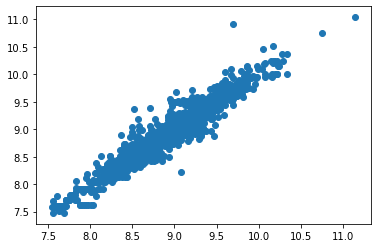

In [299]:
# plot the predicted and validated values
plt.scatter(y_pred, y_val)

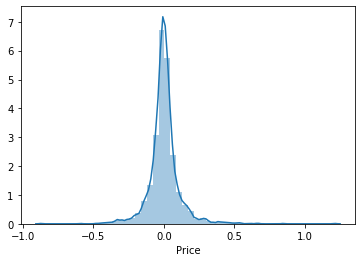

In [305]:
# plot the difference in a distribution plot
sns.distplot(y_val-y_pred)

### Generate test file

In [119]:
test_df = pd.get_dummies(test_df)
y_pred = rsearch_lgbm.predict(test_df)

In [315]:
print("Airline:",df[:train_df.shape[0]].Airline.unique())
print("Source:",df[:train_df.shape[0]].Source.unique())
print("Destination:",df[:train_df.shape[0]].Destination.unique())
print("Total_Stops:",df[:train_df.shape[0]].Total_Stops.unique())
print("Additional_Info:",df[:train_df.shape[0]].Additional_Info.unique())

Airline: ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
Source: ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
Destination: ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']
Total_Stops: [0 2 1 3 4]
Additional_Info: ['No info' 'In-flight meal not included' 'No check-in baggage included'
 '1 short layover' '1 long layover' 'Change airports' 'Business class'
 'Red-eye flight' '2 long layover']


In [316]:
print("Airline:",df[train_df.shape[0]:].Airline.unique())
print("Source:",df[train_df.shape[0]:].Source.unique())
print("Destination:",df[train_df.shape[0]:].Destination.unique())
print("Total_Stops:",df[train_df.shape[0]:].Total_Stops.unique())
print("Additional_Info:",df[train_df.shape[0]:].Additional_Info.unique())

Airline: ['Jet Airways' 'IndiGo' 'Multiple carriers' 'Air Asia' 'Air India'
 'Vistara' 'SpiceJet' 'Vistara Premium economy' 'GoAir'
 'Multiple carriers Premium economy' 'Jet Airways Business']
Source: ['Delhi' 'Kolkata' 'Banglore' 'Mumbai' 'Chennai']
Destination: ['Cochin' 'Banglore' 'Delhi' 'New Delhi' 'Hyderabad' 'Kolkata']
Total_Stops: [1 0 2 3 4]
Additional_Info: ['No info' 'In-flight meal not included' 'No check-in baggage included'
 '1 long layover' 'Business class' 'Change airports']
